In [ ]:
"I/we certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work."

'I/we certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work.'

##Prepare gym Env

In [1]:
!pip install gym 

In [2]:
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
Suggested packages:
  libgle3
The following NEW packages will be installed:
  python-opengl
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 496 kB of archives.
After this operation, 5,416 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-opengl all 3.1.0+dfsg-1 [496 kB]
Fetched 496 kB in 1s (734 kB/s)
Selecting previously unselected package python-opengl.
(Reading database ... 155202 files and directories currently installed.)
Preparing to unpack .../python-opengl_3.1.0+dfsg-1_all.deb ...
Unpacking python-opengl (3.1.0+dfsg-1) ...
Setting up python-opengl (3.1.0+dfsg-1) ...
Reading package lists... Done
Building dependency tree       
Reading s

In [3]:
import gym
import matplotlib.pyplot as plt
from gym import wrappers
%matplotlib inline

In [4]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [5]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [6]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) # error only


import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay

In [7]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [8]:
!pip install pyglet==1.5.11

     |████████████████████████████████| 1.1 MB 6.9 MB/s 
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.0
    Uninstalling pyglet-1.5.0:
      Successfully uninstalled pyglet-1.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gym 0.17.3 requires pyglet<=1.5.0,>=1.4.0, but you have pyglet 1.5.11 which is incompatible.


carpole with visualization 

In [9]:
# Render an episode and save as a GIF file

from IPython import display as ipythondisplay
from PIL import Image
from pyvirtualdisplay import Display


display = Display(visible=0, size=(400, 300))
display.start()

env = gym.make('CartPole-v1')
env.reset()
def render_episode(env: gym.Env): 
  screen = env.render(mode='rgb_array')
  im = Image.fromarray(screen)

  images = [im]

  for i in range(20):
    obs = env.reset()
    for t in range(100):
      env.render(mode='rgb_array')
      action = env.action_space.sample()
      obs,reward,done,info = env.step(action)

      # Render screen every 10 steps
      if t % 10 == 0:
        screen = env.render(mode='rgb_array')
        images.append(Image.fromarray(screen))

      if done:
        print("Episode finished after {} timesteps".format(t+1))
        break

  return images


# Save GIF image
images = render_episode(env)
image_file = 'cartpole-v1.gif'
# loop=0: loop forever, duration=1: play each frame for 1ms
images[0].save(
    image_file, save_all=True, append_images=images[1:], loop=0, duration=1)

Episode finished after 15 timesteps
Episode finished after 13 timesteps
Episode finished after 19 timesteps
Episode finished after 26 timesteps
Episode finished after 29 timesteps
Episode finished after 19 timesteps
Episode finished after 16 timesteps
Episode finished after 13 timesteps
Episode finished after 18 timesteps
Episode finished after 23 timesteps
Episode finished after 24 timesteps
Episode finished after 15 timesteps
Episode finished after 33 timesteps
Episode finished after 19 timesteps
Episode finished after 18 timesteps
Episode finished after 15 timesteps
Episode finished after 16 timesteps
Episode finished after 17 timesteps
Episode finished after 14 timesteps
Episode finished after 15 timesteps


In [10]:
import random
import math
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.distributions import Categorical

##Actor Critic in Cartpole-v1

In [11]:
#Input: a differentiable policy parameterization pi(a|s,pa)
#Input: a differentiable state-value function parameterization v(s,w)
#Parameters: step sizes alpha^pa > 0, alpha^w>0
#Initialize policy parameter theta(actor) and state-value weights w(critic) (e.g., to 0)
#for each episode
  #Initialize S (first state of episode)
  #I <- 1
  #for each time step
    #A~pi( - |S, pa)
    #Take action A, observe S', R
    #del <- R + gamma * v(S',w) - v(S,w)
    #w<- w + alph^w*delta*diff v(S,w)
    #theta <- theta + alpha^theta*delta*ln pi(A|S,theta)
    #I<-gamma*I
    #S<-S'

In [12]:
#Neural Network Model for Actor and Critic 
class ActorCritic(nn.Module):
  def __init__(self,obs_space,action_space):
    super(ActorCritic, self).__init__()
    self.obs_space = obs_space
    self.action_space = action_space
    self.linear = nn.Linear(self.obs_space,128)
    self.actor = nn.Linear(128,self.action_space)
    self.critic = nn.Linear(128,1)
    
  def Actor(self, state):
    output = F.relu(self.linear(state))
    output = F.softmax(self.actor(output))
    return output
  
  def Critic(self, state):
    output = F.relu(self.linear(state))
    output = self.critic(output)
    return output 

In [13]:
env = gym.make('CartPole-v1')
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
ac = ActorCritic(obs_space,action_space)
optimizer = optim.Adam(ac.parameters())

rewards = []
episode_list = []


for ep in range(1500): #for each episode
  #Initialize S
  state = env.reset()
  loss = 0 
  cumulative_rewards = 0
  for t in range(200): #for each timesteps
    
    state = torch.FloatTensor(state) 
    env.render()

    #Take action A, observe S', R
    probs = ac.Actor(state)
    m = Categorical(probs)
    action = m.sample()
    next_state, reward, done, _ = env.step(action.numpy())
  
    cumulative_rewards+=reward

    #advantage function = TD error
    #a <- R + gamma * v(S',w) - v(S,w)
    value = ac.Critic(state)
    next_state = torch.FloatTensor(next_state)
    next_value = ac.Critic(next_state)
    
    if done:
      target = torch.tensor(reward) 
    else:
      target = torch.tensor(reward) + 0.99 * next_value 

    #update critic by minimizing loss
    lossC = F.smooth_l1_loss(target, value)

    #update actor by minimizing loss
    lossA = -m.log_prob(action) * (target-value)
    loss += lossC + lossA

    #S<-S'
    state = next_state

    if done:
      break 


  #backpropagation 
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
    

  if (ep)%10== 0 : 
    print('episode:',ep,end=' ')
    print('rewards:',cumulative_rewards)

  episode_list.append(ep)
  rewards.append(cumulative_rewards)


env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


episode: 0 rewards: 41.0
episode: 10 rewards: 12.0
episode: 20 rewards: 11.0
episode: 30 rewards: 10.0
episode: 40 rewards: 22.0
episode: 50 rewards: 10.0
episode: 60 rewards: 10.0
episode: 70 rewards: 9.0
episode: 80 rewards: 16.0
episode: 90 rewards: 13.0
episode: 100 rewards: 10.0
episode: 110 rewards: 22.0
episode: 120 rewards: 12.0
episode: 130 rewards: 13.0
episode: 140 rewards: 11.0
episode: 150 rewards: 11.0
episode: 160 rewards: 17.0
episode: 170 rewards: 23.0
episode: 180 rewards: 17.0
episode: 190 rewards: 20.0
episode: 200 rewards: 28.0
episode: 210 rewards: 14.0
episode: 220 rewards: 30.0
episode: 230 rewards: 21.0
episode: 240 rewards: 48.0
episode: 250 rewards: 27.0
episode: 260 rewards: 54.0
episode: 270 rewards: 69.0
episode: 280 rewards: 75.0
episode: 290 rewards: 37.0
episode: 300 rewards: 43.0
episode: 310 rewards: 58.0
episode: 320 rewards: 37.0
episode: 330 rewards: 66.0
episode: 340 rewards: 49.0
episode: 350 rewards: 98.0
episode: 360 rewards: 53.0
episode: 370 

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

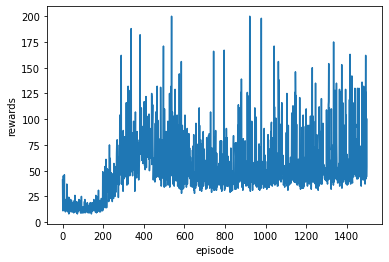

<IPython.core.display.Javascript object>

In [14]:
#rewards per episode 
from google.colab import widgets
output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  plt.plot(episode_list,rewards)
  plt.xlabel("episode")
  plt.ylabel("rewards")

Evaluation

In [15]:
ev_result = []
ev_ep = []
episode = 100

for ep in range (1,episode+1):
  state= env.reset()
  done = False
  cumulative_rewards = 0 
  for t in range(200):
    state = torch.FloatTensor(state) 
    env.render()
    probs = ac.Actor(state)
    action = torch.argmax(probs)
    next_state, reward, done, _ = env.step(action.numpy())
    cumulative_rewards+=reward
    state = next_state

    if done:
      break 
  
  print("--------------------------------")  
  print('episode:',ep)
  print('rewards:',cumulative_rewards)

      
  ev_ep.append(ep)
  ev_result.append(cumulative_rewards)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


--------------------------------
episode: 1
rewards: 56.0
--------------------------------
episode: 2
rewards: 77.0
--------------------------------
episode: 3
rewards: 46.0
--------------------------------
episode: 4
rewards: 42.0
--------------------------------
episode: 5
rewards: 62.0
--------------------------------
episode: 6
rewards: 60.0
--------------------------------
episode: 7
rewards: 51.0
--------------------------------
episode: 8
rewards: 64.0
--------------------------------
episode: 9
rewards: 56.0
--------------------------------
episode: 10
rewards: 110.0
--------------------------------
episode: 11
rewards: 118.0
--------------------------------
episode: 12
rewards: 93.0
--------------------------------
episode: 13
rewards: 55.0
--------------------------------
episode: 14
rewards: 58.0
--------------------------------
episode: 15
rewards: 54.0
--------------------------------
episode: 16
rewards: 59.0
--------------------------------
episode: 17
rewards: 46.0
----

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

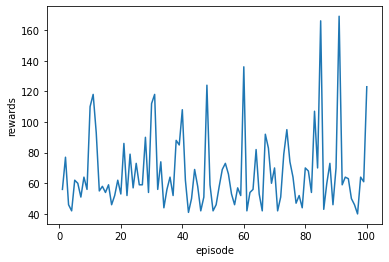

<IPython.core.display.Javascript object>

In [16]:
#rewards per episode 
with output_grid.output_to(0, 0):
  plt.plot(ev_ep,ev_result)
  plt.xlabel("episode")
  plt.ylabel("rewards")

## Actor-Critic in LunarLander

In [ ]:
import urllib.request
urllib.request.urlretrieve('http://www.atarimania.com/roms/Roms.rar','Roms.rar')
!pip install unrar
!unrar x Roms.rar
!mkdir rars
!mv HC\ ROMS.zip   rars
!mv ROMS.zip  rars
!python -m atari_py.import_roms rars


스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Extracting  ROMS/Air-Sea Battle - Air Sea Battle (Anti-Aircraft) (1977) (Atari, Larry Kaplan) (CX2602, CX2602P) (PAL).bin       1%  OK 
Extracting  ROMS/Air-Sea Battle - Air Sea Battle - Target Fun (Anti-Aircraft) (1977) (Atari, Larry Kaplan - Sears) (CX2602 - 99802, 6-99802, 49-75102) ~.bin       1%  OK 
Extracting  ROMS/Airlock (1982) (Data Age) (DA1004) (Prototype).bin        1%  OK 
Extracting  ROMS/Airlock (1982) (Data Age) (DA1004) ~.bin                  1%  OK 
Extracting  ROMS/Airlock (1983) (Gameworld) (133-004) (PAL).bin            1%  OK 
Extracting  ROMS/Alices Abenteuer - Lilly Adventure (1983) (Quelle - Otto Versand) (732.273 8 - 600273, 781644) (PAL).bin       1%  OK 
Extracting  ROMS/Alien (1982) (20th Century Fox Video Games, Douglas 'Dallas North' Neubauer) (11006) ~.bin       1%  OK 
Extracting  ROMS/Alien (CCE).bin                                           2% 

In [ ]:
!pip install gym[box2d]

     |████████████████████████████████| 1.0 MB 26.7 MB/s 
     |████████████████████████████████| 448 kB 55.0 MB/s 
  Attempting uninstall: pyglet
    Found existing installation: pyglet 1.5.11
    Uninstalling pyglet-1.5.11:
      Successfully uninstalled pyglet-1.5.11


In [ ]:
!pip install -f https://github.com/Kojoley/atari-py/releases atari_py
!pip install git+https://github.com/Kojoley/atari-py.git

Looking in links: https://github.com/Kojoley/atari-py/releases
  Cloning https://github.com/Kojoley/atari-py.git to /tmp/pip-req-build-wqoof9pz
  Running command git clone -q https://github.com/Kojoley/atari-py.git /tmp/pip-req-build-wqoof9pz
  Created wheel for atari-py: filename=atari_py-1.2.2-cp37-cp37m-linux_x86_64.whl size=3910614 sha256=c47cbf8aafdd92df99ce8174f17e37702165ae90166f3e3fc2ef80f75a53d5c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-wmwhjy1n/wheels/c0/86/e3/29cca012bdc1e9de00a08ad390ac2998a54a094330529bca62
Successfully built atari-py
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


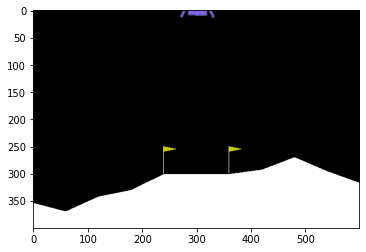

Observation space: Box(-inf, inf, (8,), float32)
Action space: Discrete(4)


In [ ]:
env = gym.make('LunarLander-v2')

plt.imshow(env.render('rgb_array'))
plt.show()
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

In [ ]:
env = gym.make('LunarLander-v2')
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n
ac = ActorCritic(obs_space,action_space)
optimizer = optim.Adam(ac.parameters())

rewards = []
episode_list = []


for ep in range(1500): #for each episode
  #Initialize S
  state = env.reset()
  loss = 0 
  cumulative_rewards = 0
  for t in range(200): #for each timesteps
    
    state = torch.FloatTensor(state) 
    env.render()

    #Take action A, observe S', R
    probs = ac.Actor(state)
    m = Categorical(probs)
    action = m.sample()
    next_state, reward, done, _ = env.step(action.numpy())
  
    cumulative_rewards+=reward

    #advantage function = TD error
    #a <- R + gamma * v(S',w) - v(S,w)
    value = ac.Critic(state)
    next_state = torch.FloatTensor(next_state)
    next_value = ac.Critic(next_state)
    
    if done:
      target = torch.tensor(reward) 
    else:
      target = torch.tensor(reward) + 0.99 * next_value 

    #update critic by minimizing loss
    lossC = F.smooth_l1_loss(target, value)

    #update actor by minimizing loss
    lossA = -m.log_prob(action) * (target-value)
    loss += lossC + lossA

    #S<-S'
    state = next_state

    if done:
      break 


  #backpropagation 
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
    

  if (ep)%10== 0 : 
    print('episode:',ep,end=' ')
    print('rewards:',cumulative_rewards)

  episode_list.append(ep)
  rewards.append(cumulative_rewards)


env.close()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


episode: 0 rewards: -81.10495344592456
episode: 10 rewards: -271.04990568487926
episode: 20 rewards: -105.38672917150888
episode: 30 rewards: -153.09347371940672
episode: 40 rewards: -141.37391276951186
episode: 50 rewards: -118.49538490986951
episode: 60 rewards: -76.1518282937992
episode: 70 rewards: -184.82318736536504
episode: 80 rewards: -102.97118413042266
episode: 90 rewards: -156.07732556399486
episode: 100 rewards: -72.5777450158644
episode: 110 rewards: -319.35814165698764
episode: 120 rewards: -473.2339716705023
episode: 130 rewards: -18.651141474273203
episode: 140 rewards: -286.79470317202026
episode: 150 rewards: -58.03464137322757
episode: 160 rewards: -138.53610212914194
episode: 170 rewards: -46.87524498658183
episode: 180 rewards: -124.23088072332249
episode: 190 rewards: -339.01619033675377
episode: 200 rewards: -132.44744683496427
episode: 210 rewards: -178.25377131529453
episode: 220 rewards: -462.8863208014924
episode: 230 rewards: -165.43398469578716
episode: 240

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

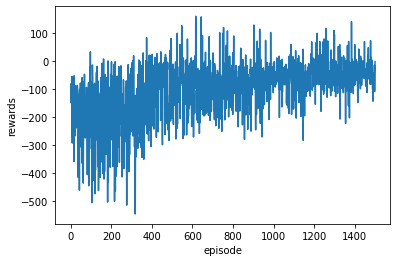

<IPython.core.display.Javascript object>

In [ ]:
#rewards per episode 
from google.colab import widgets
output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  plt.plot(episode_list,rewards)
  plt.xlabel("episode")
  plt.ylabel("rewards")

evaluation

In [ ]:
ev_result = []
ev_ep = []
episode = 100 

for ep in range (1,episode+1):
  state= env.reset()
  done = False
  cumulative_rewards = 0 
  for t in range(200):
    state = torch.FloatTensor(state) 
    env.render()
    probs = ac.Actor(state)
    action = torch.argmax(probs)
    next_state, reward, done, _ = env.step(action.numpy())
    cumulative_rewards+=reward
    state = next_state

    if done:
      break 
  
  print("--------------------------------")  
  print('episode:',ep)
  print('rewards:',cumulative_rewards)

      
  ev_ep.append(ep)
  ev_result.append(cumulative_rewards)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


--------------------------------
episode: 1
rewards: -14.39332510799962
--------------------------------
episode: 2
rewards: -14.966080022114612
--------------------------------
episode: 3
rewards: -18.58740677713865
--------------------------------
episode: 4
rewards: -55.552456384538154
--------------------------------
episode: 5
rewards: -19.137900034972898
--------------------------------
episode: 6
rewards: -22.848453177107565
--------------------------------
episode: 7
rewards: -8.120999541217673
--------------------------------
episode: 8
rewards: 1.013656742452683
--------------------------------
episode: 9
rewards: -31.597221406186698
--------------------------------
episode: 10
rewards: -14.073848314836113
--------------------------------
episode: 11
rewards: -46.33459770631037
--------------------------------
episode: 12
rewards: -21.872425025086873
--------------------------------
episode: 13
rewards: -59.78591424301872
--------------------------------
episode: 14
rewards: 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

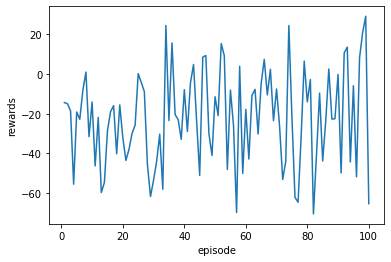

<IPython.core.display.Javascript object>

In [ ]:
#rewards per episode 
with output_grid.output_to(0, 0):
  plt.plot(ev_ep,ev_result)
  plt.xlabel("episode")
  plt.ylabel("rewards")

##Actor-Critic in MultiAgentEnvironment


In [ ]:
import numpy as np
import gym
from gym import spaces
import copy
from copy import copy
import matplotlib.pyplot as plt

In [ ]:
class MAGridWorld(gym.Env):
    
    metadata = { 'render.modes' : ['human', 'rgb_array'] }
        
    def __init__(self, size, n_agents):
        self.size = size
        self._grid_size = (self.size, self.size)
        self.world = np.zeros((self._grid_size))
        self._timestep = None
        self._max_timestep = int(self.size*4)
        self.n_agents = n_agents
        self.dist = int((self.size-1)/(n_agents-1))
        self._step_cost = -0.1
        self.observation_space = spaces.Box(low=0, high=self.size, shape=(self.size, self.size))
        self.action_space = spaces.Discrete(5)

    def reset(self):
        self.agent_pos = []
        self.goal_pos = []
        self._timestep = 0
        self.done = [False for i in range(self.n_agents)] #agent 수 만큼 done개수 필요 
        for i in range(self.n_agents):
            self.agent_pos.append([self.size-1, i*self.dist])
            self.goal_pos.append([0, i*self.dist])
        self.goal_pos.reverse()
        observation = self.agent_pos
        return observation


    def _compute_distance(self, x, y):
        dist = np.abs(x[0]-y[0]) + np.abs(x[1]-y[1])
        return dist


    def _is_inside_grid(self, pos):
        return (0 <= pos[0] < self._grid_size[0]) and (0 <= pos[1] < self._grid_size[1])


    def _is_collision(self, new_pos, agent):
        for i in range(self.n_agents):
            if i == agent:
                continue
            elif new_pos == self.agent_pos[i]:
                return True
            elif new_pos == self.goal_pos[i]:
                return True

    def step(self, actions):
        self._timestep += 1
        old_pos = self.agent_pos.copy()
        rewards = [0 for _ in range(self.n_agents)]

        for i in range(self.n_agents):
            self.update_agent_pos(i, actions[i])
            old_dist = self._compute_distance(old_pos[i], self.goal_pos[i])
            new_dist = self._compute_distance(self.agent_pos[i], self.goal_pos[i])
            
            if new_dist < old_dist:
                rewards[i] = -0.1
            elif new_dist > old_dist:
                rewards[i] = -0.5

            elif (new_dist == old_dist) and not self.done[i]:
                rewards[i] = -0.5
            
            if (self.agent_pos[i] == self.goal_pos[i]):
                self.done[i] = True
                rewards[i] = 1
            else:
                self.done[i] = False

        if self._timestep >= self._max_timestep:
            self.done = [True for i in range(self.n_agents)]
            
        observation = self.agent_pos
        info = {}
        return observation, rewards, self.done, info #all(done)



    def update_agent_pos(self, agent, action):
        next_pos = copy(self.agent_pos[agent])
        if action == 0: # Down
            next_pos[0] += 1
        elif action == 1: # Up
            next_pos[0] -= 1
        elif action == 2: # Right
            next_pos[1] += 1
        elif action == 3: # Left
            next_pos[1] -= 1
        elif action == 4: # No move
            pass
        else:
            raise Exception('Action is not valid')
            
        if self._is_inside_grid(next_pos) and not self._is_collision(next_pos, agent):
            self.agent_pos[agent] = next_pos
        else:
            pass
        

    def render(self):
        state = np.copy(self.world)
        for i in range(self.n_agents):
            state[tuple(self.agent_pos[i])] = 1 - (0.1 * i)
            state[tuple(self.goal_pos[i])] = 1 - (0.1 * i)
        return plt.imshow(state)

In [ ]:
config = {
    'N_AGENTS': 6,
    'GRID_SIZE': 6
}

state [[4, 0], [4, 1], [4, 2], [5, 3], [4, 4], [5, 4]]
reward [-0.1, -0.1, -0.1, -0.5, -0.1, -0.1]
done [False, False, False, False, False, False]


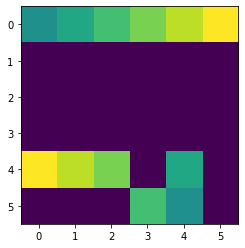

In [ ]:
if __name__ == '__main__':
    n_agents = config['N_AGENTS']
    size = config['GRID_SIZE']
    env = MAGridWorld(size=size, n_agents=n_agents)
    env.reset()
    env.render()
    action_n = [1, 1, 1, 0, 1, 3]
    state, reward, done, _ = env.step(action_n)
    print('state', state)
    print('reward', reward)
    print('done', done)
    env.render()

goal_pos [[0, 5], [0, 4], [0, 3], [0, 2], [0, 1], [0, 0]]
agent_pos [[5, 0], [5, 1], [5, 2], [5, 3], [5, 4], [5, 5]]
episode: 0 rewards: -3.0
episode: 10 rewards: -2.6
episode: 20 rewards: -3.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


episode: 30 rewards: -3.0
episode: 40 rewards: -3.0
episode: 50 rewards: -2.6
episode: 60 rewards: -3.0
episode: 70 rewards: -3.0
episode: 80 rewards: -3.0
episode: 90 rewards: -3.0
episode: 100 rewards: -1.4000000000000004
episode: 110 rewards: -3.0
episode: 120 rewards: -2.6
episode: 130 rewards: -1.8
episode: 140 rewards: -0.6
episode: 150 rewards: -0.6
episode: 160 rewards: -0.9999999999999999
episode: 170 rewards: -0.6
episode: 180 rewards: -0.6
episode: 190 rewards: -0.6
episode: 200 rewards: -0.6
episode: 210 rewards: -0.6
episode: 220 rewards: -0.6
episode: 230 rewards: -0.6
episode: 240 rewards: -0.6
episode: 250 rewards: -0.6
episode: 260 rewards: -0.6
episode: 270 rewards: -0.6
episode: 280 rewards: -0.6
episode: 290 rewards: -0.6
episode: 300 rewards: -0.6
episode: 310 rewards: -0.6
episode: 320 rewards: -0.6
episode: 330 rewards: -0.6
episode: 340 rewards: -0.6
episode: 350 rewards: -0.6
episode: 360 rewards: -0.6
episode: 370 rewards: -0.6
episode: 380 rewards: -0.6
episo

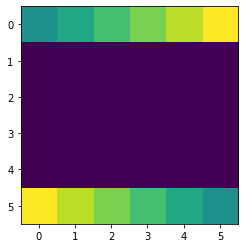

In [ ]:
n_agents = config['N_AGENTS']
size = config['GRID_SIZE']
env = MAGridWorld(size=size,n_agents=n_agents)
action_space = env.action_space.n
ac = ActorCritic(2,action_space)
optimizer = optim.Adam(ac.parameters())

rewards = []
episode_list = []

obs = env.reset()
print('goal_pos', env.goal_pos)
print('agent_pos', obs)


for ep in range(1500): #for each episode
  #Initialize S
  state = env.reset()
  loss = 0 
  cumulative_rewards = 0
  for t in range(200): #for each timesteps
    state = torch.FloatTensor(state) 
    env.render()

    #Take action A, observe S', R
    probs = ac.Actor(state)
    m = Categorical(probs)
    action = m.sample()
    next_state, reward, done, _ = env.step(action)

    #advantage function = TD error
    #a <- R + gamma * v(S',w) - v(S,w)
    value = ac.Critic(state)
    next_state = torch.FloatTensor(next_state)
    next_value = ac.Critic(next_state)
    
    if done:
      target = torch.tensor(reward) 
    else:
      target = torch.tensor(reward) + 0.99 * next_value 

    #update critic by minimizing loss
    lossC = F.smooth_l1_loss(target, value)

    #update actor by minimizing loss
    lossA = -m.log_prob(action) * (target-value)
    loss += lossC + lossA.mean()

    #S<-S'
    state = next_state
    sum_reward_agent = 0
    for i in reward:
      sum_reward_agent+=i
    cumulative_rewards += sum_reward_agent

    if done:
      break 


  #backpropagation 
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
    
    

  if (ep)%10== 0 : 
    print('episode:',ep,end=' ')
    print('rewards:',cumulative_rewards)

  episode_list.append(ep)
  rewards.append(cumulative_rewards)

env.close()

""


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

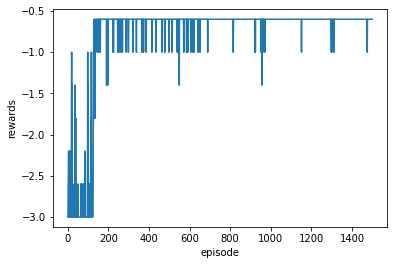

<IPython.core.display.Javascript object>

In [ ]:
#rewards per episode 
from google.colab import widgets
output_grid = widgets.Grid(1, 1)
with output_grid.output_to(0, 0):
  plt.plot(episode_list,rewards)
  plt.xlabel("episode")
  plt.ylabel("rewards")

evaluation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


--------------------------------
episode: 1
rewards: -0.6
--------------------------------
episode: 2
rewards: -0.6
--------------------------------
episode: 3
rewards: -0.6
--------------------------------
episode: 4
rewards: -0.6
--------------------------------
episode: 5
rewards: -0.6
--------------------------------
episode: 6
rewards: -0.6
--------------------------------
episode: 7
rewards: -0.6
--------------------------------
episode: 8
rewards: -0.6
--------------------------------
episode: 9
rewards: -0.6
--------------------------------
episode: 10
rewards: -0.6
--------------------------------
episode: 11
rewards: -0.6
--------------------------------
episode: 12
rewards: -0.6
--------------------------------
episode: 13
rewards: -0.6
--------------------------------
episode: 14
rewards: -0.6
--------------------------------
episode: 15
rewards: -0.6
--------------------------------
episode: 16
rewards: -0.6
--------------------------------
episode: 17
rewards: -0.6
------

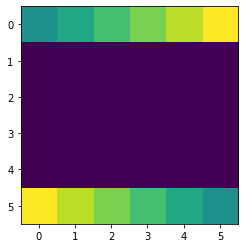

In [ ]:
ev_result = []
ev_ep = []
episode = 100 

for ep in range (1,episode+1):
  state= env.reset()
  done = False
  cumulative_rewards = 0 
  for t in range(200):
    state = torch.FloatTensor(state) 
    env.render()
    probs = ac.Actor(state)
    prob = []
    for i in range(n_agents):
      prob.append(np.argmax(probs[i].detach()))
    action = torch.tensor(prob)
    next_state, reward, done, _ = env.step(action)

    sum_reward_agent = 0
    for i in reward:
      sum_reward_agent+=i
    cumulative_rewards += sum_reward_agent
    
    state = next_state

    if done:
      break 
  
  print("--------------------------------")  
  print('episode:',ep)
  print('rewards:',cumulative_rewards)

      
  ev_ep.append(ep)
  ev_result.append(cumulative_rewards)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

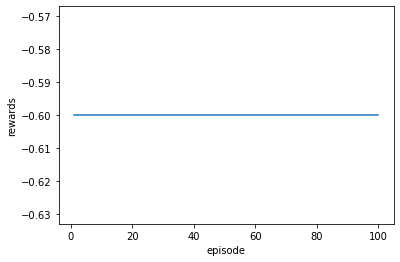

<IPython.core.display.Javascript object>

In [ ]:
#rewards per episode 
with output_grid.output_to(0, 0):
  plt.plot(ev_ep,ev_result)
  plt.xlabel("episode")
  plt.ylabel("rewards")